<a href="https://colab.research.google.com/github/M-Mag25/Group-Work-Project-1-/blob/main/GWP2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Group FE Group Work Project 1 M5: Financial Econometrics Analysis (Student Group 12212)**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

All necessary libraries imported successfully!

CHALLENGE 1: NON-STATIONARITY & COINTEGRATION

1. Data Preparation...
  'Adj Close' not found for SP500. Falling back to 'Close'.
  'Adj Close' not found for NASDAQ. Falling back to 'Close'.
Data period: 2015-01-02 to 2023-12-29
Number of observations: 2264

2. Stationarity Tests (ADF)...
SP500 Price: ADF Statistic = -0.4170, p-value = 0.9072
  → Stationary: False


NASDAQ Price: ADF Statistic = -0.3801, p-value = 0.9134
  → Stationary: False
SP500 Returns: ADF Statistic = -14.8159, p-value = 0.0000
  → Stationary: True
NASDAQ Returns: ADF Statistic = -15.5188, p-value = 0.0000
  → Stationary: True

3. Cointegration Test (Engle-Granger)...
Cointegration test statistic: -1.9597
p-value: 0.5494
Critical values: [-3.90128824 -3.33883253 -3.04632551]
Cointegrated: False

5. Essential Visualizations...


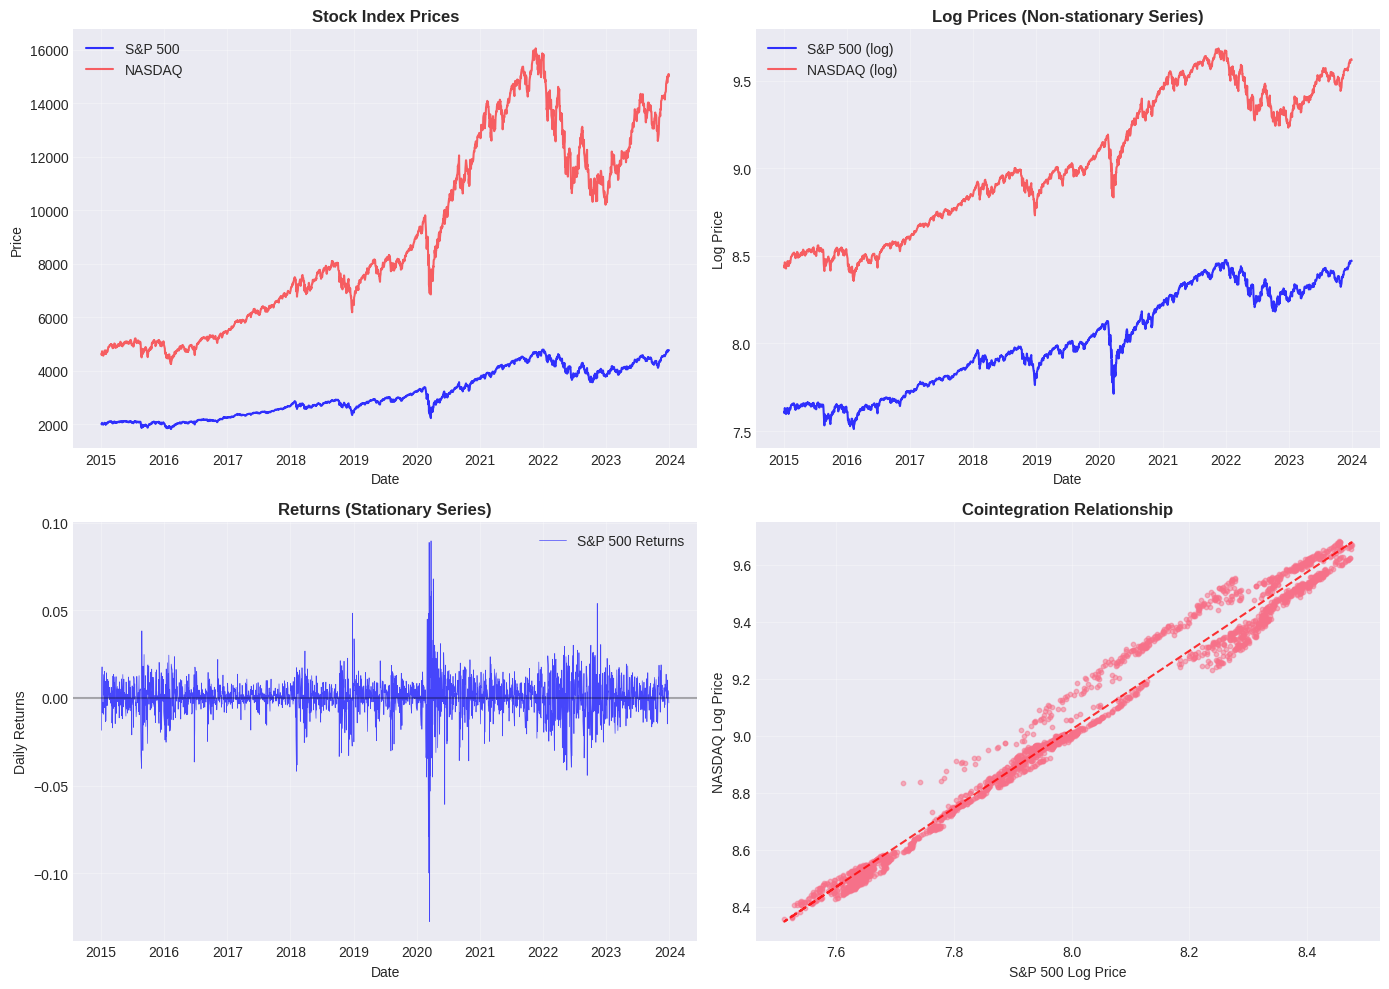

In [3]:
# ============================================
# Financial Econometrics - Project 2
# Python Code for Three Challenges
# ============================================

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistics and econometrics libraries
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.stats.diagnostic import breaks_cusumolsresid
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import acf
from statsmodels.regression.linear_model import OLS # Import OLS for CUSUM test
import statsmodels.api as sm # Import statsmodels.api for add_constant

# Machine learning libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Financial data
import yfinance as yf
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All necessary libraries imported successfully!")

# ============================================
# CHALLENGE 1: NON-STATIONARITY & COINTEGRATION
# Dataset: S&P 500 and NASDAQ Composite
# ============================================

def challenge_1_nonstationarity():
    """
    Handle non-stationarity and cointegration analysis
    """
    print("\n" + "="*60)
    print("CHALLENGE 1: NON-STATIONARITY & COINTEGRATION")
    print("="*60)

    # 1.1 Data preparation
    print("\n1. Data Preparation...")

    # Download data
    start_date = '2015-01-01'
    end_date = '2023-12-31'

    # Download data for each ticker separately to avoid MultiIndex complexities
    sp500_data = yf.download('^GSPC', start=start_date, end=end_date)
    nasdaq_data = yf.download('^IXIC', start=start_date, end=end_date)

    # Helper function to get 'Adj Close' or fallback to 'Close'
    def get_price_series(df, name):
        selected_series = None
        if 'Adj Close' in df.columns:
            print(f"  Using 'Adj Close' for {name}")
            selected_series = df['Adj Close']
        elif 'Close' in df.columns:
            print(f"  'Adj Close' not found for {name}. Falling back to 'Close'.")
            selected_series = df['Close']
        else:
            # If neither column is found, return an empty Series
            print(f"  ERROR: Neither 'Adj Close' nor 'Close' found for {name} data. Returning empty Series.")
            return pd.Series(dtype=float) # Ensure returning a Series

        # Ensure selected_series is always a Series. If it's a DataFrame (e.g., single-column DataFrame), convert it.
        if isinstance(selected_series, pd.DataFrame):
            if selected_series.shape[1] == 1:
                selected_series = selected_series.iloc[:, 0] # Convert single-column DataFrame to Series
                print(f"  Warning: {name} price data was a single-column DataFrame. Converted to Series.")
            else:
                # If it's a multi-column DataFrame, this is unexpected for a single column selection
                print(f"  ERROR: {name} price data unexpectedly resulted in a multi-column DataFrame. Returning empty Series.")
                return pd.Series(dtype=float)

        # Now selected_series should either be a pd.Series or a scalar (if original df had only one row/cell)
        if not isinstance(selected_series, pd.Series):
            # This branch handles the scalar case
            print(f"  Warning: {name} price data was not a Series (scalar). Attempting to convert to Series.")
            if selected_series is None or pd.isna(selected_series):
                return pd.Series(dtype=float)
            elif not df.empty and df.index is not None and not df.index.empty:
                return pd.Series([selected_series], index=[df.index[-1]])
            else:
                return pd.Series([selected_series])

        return selected_series

    # Extract prices using the helper function
    sp500_prices = get_price_series(sp500_data, 'SP500')
    nasdaq_prices = get_price_series(nasdaq_data, 'NASDAQ')

    # Combine into a single DataFrame using concat for robustness and index alignment
    # If one series is empty or has non-overlapping dates, concat will handle NaNs.
    data = pd.concat({'SP500': sp500_prices, 'NASDAQ': nasdaq_prices}, axis=1)
    data = data.dropna()

    print(f"Data period: {data.index[0].date()} to {data.index[-1].date()}")
    print(f"Number of observations: {len(data)}")

    # Calculate log prices and returns
    data['log_SP500'] = np.log(data['SP500'])
    data['log_NASDAQ'] = np.log(data['NASDAQ'])
    data['returns_SP500'] = data['log_SP500'].diff()
    data['returns_NASDAQ'] = data['log_NASDAQ'].diff()
    data = data.dropna()

    # 1.2 Stationarity tests (ADF)
    print("\n2. Stationarity Tests (ADF)...")

    def perform_adf_test(series, name):
        """Perform Augmented Dickey-Fuller test"""
        result = adfuller(series)
        is_stationary = result[1] < 0.05
        print(f"{name}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")
        print(f"  → Stationary: {is_stationary}")
        return is_stationary

    # Test different series
    series_dict = {
        'SP500 Price': data['SP500'],
        'NASDAQ Price': data['NASDAQ'],
        'SP500 Returns': data['returns_SP500'],
        'NASDAQ Returns': data['returns_NASDAQ']
    }

    for name, series in series_dict.items():
        perform_adf_test(series, name)

    # 1.3 Cointegration test
    print("\n3. Cointegration Test (Engle-Granger)...")

    coint_test = coint(data['log_SP500'], data['log_NASDAQ'])
    print(f"Cointegration test statistic: {coint_test[0]:.4f}")
    print(f"p-value: {coint_test[1]:.4f}")
    print(f"Critical values: {coint_test[2]}")

    is_cointegrated = coint_test[1] < 0.05
    print(f"Cointegrated: {is_cointegrated}")

    # 1.4 VECM model if cointegrated
    if is_cointegrated:
        print("\n4. Vector Error Correction Model (VECM)...")

        # Prepare data
        log_data = data[['log_SP500', 'log_NASDAQ']]

        # Fit VECM
        vecm_model = VECM(log_data, k_ar_diff=2, coint_rank=1, deterministic='ci')
        vecm_result = vecm_model.fit()

        print("VECM Model Summary:")
        print("-" * 40)
        print(f"Number of cointegrating relations: {vecm_result.coint_rank}")
        print(f"Log Likelihood: {vecm_result.llf:.2f}")
        print(f"AIC: {vecm_result.aic:.2f}")
        print(f"BIC: {vecm_result.bic:.2f}")

        # Error correction term
        ecm_term = vecm_result.resid

        # Plot error correction term
        plt.figure(figsize=(12, 5))
        plt.plot(ecm_term, label='Error Correction Term', color='darkblue', linewidth=1.5)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        plt.axhline(y=ecm_term.mean() + 2*ecm_term.std(), color='gray', linestyle=':', alpha=0.5)
        plt.axhline(y=ecm_term.mean() - 2*ecm_term.std(), color='gray', linestyle=':', alpha=0.5)
        plt.title('Error Correction Term: S&P 500 vs NASDAQ', fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Deviation from Long-run Equilibrium')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('vecm_error_correction.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 1.5 Plot essential visualizations
    print("\n5. Essential Visualizations...")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Price series
    axes[0, 0].plot(data['SP500'], label='S&P 500', color='blue', alpha=0.8)
    axes[0, 0].plot(data['NASDAQ'], label='NASDAQ', color='red', alpha=0.6)
    axes[0, 0].set_title('Stock Index Prices', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Log prices (highlight non-stationarity)
    axes[0, 1].plot(data['log_SP500'], label='S&P 500 (log)', color='blue', alpha=0.8)
    axes[0, 1].plot(data['log_NASDAQ'], label='NASDAQ (log)', color='red', alpha=0.6)
    axes[0, 1].set_title('Log Prices (Non-stationary Series)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Log Price')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Returns (stationary series)
    axes[1, 0].plot(data['returns_SP500'], label='S&P 500 Returns', color='blue', alpha=0.7, linewidth=0.5)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 0].set_title('Returns (Stationary Series)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Daily Returns')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Scatter plot of log prices
    axes[1, 1].scatter(data['log_SP500'], data['log_NASDAQ'], alpha=0.5, s=10)
    axes[1, 1].set_title('Cointegration Relationship', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('S&P 500 Log Price')
    axes[1, 1].set_ylabel('NASDAQ Log Price')

    # Add regression line
    z = np.polyfit(data['log_SP500'], data['log_NASDAQ'], 1)
    p = np.poly1d(z)
    axes[1, 1].plot(data['log_SP500'], p(data['log_SP500']), "r--", alpha=0.8)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('nonstationarity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    return data, is_cointegrated

# Execute Challenge 1
data_ch1, is_cointegrated = challenge_1_nonstationarity()






CHALLENGE 2: REGIME CHANGE DETECTION

1. Data Preparation...


[*********************100%***********************]  1 of 1 completed


  'Adj Close' not found for VIX. Falling back to 'Close'.
VIX data period: 2005-01-03 to 2023-12-29
Number of observations: 4781
VIX mean: 19.34
VIX std: 8.94

2. Structural Break Test (CUSUM)...
CUSUM test statistic: 7.3706
Critical value (5%): 1.3013018575602535e-47
Structural break detected: True

3. Markov Switching Autoregressive Model...
Markov Switching model failed: SVD did not converge
Using simple threshold-based regime detection instead...


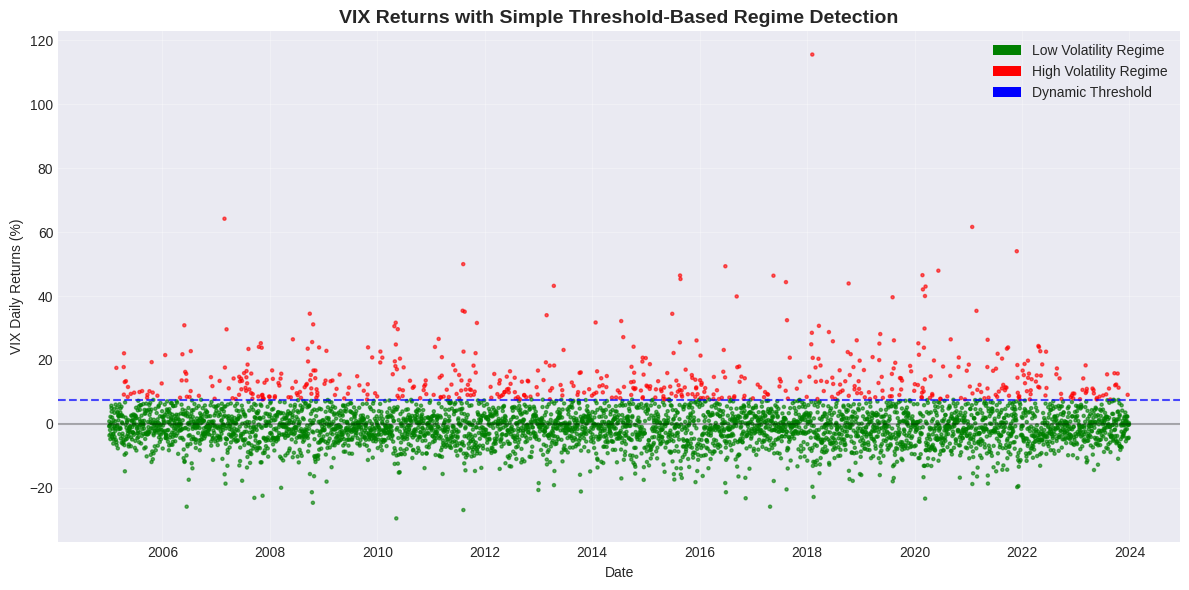

In [4]:
# ============================================
# CHALLENGE 2: REGIME CHANGE DETECTION
# Dataset: VIX Volatility Index
# ============================================

def challenge_2_regime_change():
    """
    Detect and model regime changes in financial time series
    """
    print("\n" + "="*60)
    print("CHALLENGE 2: REGIME CHANGE DETECTION")
    print("="*60)

    # 2.1 Data preparation
    print("\n1. Data Preparation...")

    # Download VIX data
    start_date = '2005-01-01'
    end_date = '2023-12-31'

    vix_data_raw = yf.download('^VIX', start=start_date, end=end_date)
    # Helper to get 'Adj Close' or fallback to 'Close' for VIX
    def get_vix_price_series(df):
        selected_series = None
        if 'Adj Close' in df.columns:
            print(f"  Using 'Adj Close' for VIX")
            selected_series = df['Adj Close']
        elif 'Close' in df.columns:
            print(f"  'Adj Close' not found for VIX. Falling back to 'Close'.")
            selected_series = df['Close']
        else:
            # If neither column is found, return an empty Series
            print(f"  ERROR: Neither 'Adj Close' nor 'Close' found for VIX data. Returning empty Series.")
            return pd.Series(dtype=float)

        # Ensure selected_series is always a Series. If it's a DataFrame (e.g., single-column DataFrame), convert it.
        if isinstance(selected_series, pd.DataFrame):
            if selected_series.shape[1] == 1:
                selected_series = selected_series.iloc[:, 0] # Convert single-column DataFrame to Series
                print(f"  Warning: VIX price data was a single-column DataFrame. Converted to Series.")
            else:
                # If it's a multi-column DataFrame, this is unexpected for a single column selection
                print(f"  ERROR: VIX price data unexpectedly resulted in a multi-column DataFrame. Returning empty Series.")
                return pd.Series(dtype=float)

        # Now selected_series should either be a pd.Series or a scalar (if original df had only one row/cell)
        if not isinstance(selected_series, pd.Series):
            # This branch handles the scalar case
            print(f"  Warning: VIX price data was not a Series (scalar). Attempting to convert to Series.")
            if selected_series is None or pd.isna(selected_series):
                return pd.Series(dtype=float)
            elif not df.empty and df.index is not None and not df.index.empty:
                return pd.Series([selected_series], index=[df.index[-1]])
            else:
                return pd.Series([selected_series])

        return selected_series

    vix_data = get_vix_price_series(vix_data_raw)
    vix_data.name = 'VIX'
    vix_data = vix_data.dropna()

    print(f"VIX data period: {vix_data.index[0].date()} to {vix_data.index[-1].date()}")
    print(f"Number of observations: {len(vix_data)}")
    print(f"VIX mean: {vix_data.mean():.2f}")
    print(f"VIX std: {vix_data.std():.2f}")

    # 2.2 Structural break test
    print("\n2. Structural Break Test (CUSUM)...")

    # Prepare data for OLS regression
    y_ols = vix_data.values
    # Use a constant and a time trend as regressors
    X_ols = sm.add_constant(np.arange(len(vix_data)))

    # Fit OLS model to get residuals
    ols_model = OLS(y_ols, X_ols)
    ols_results = ols_model.fit()
    residuals = ols_results.resid
    # ddof is the number of regressors (constant + trend = 2)
    ddof = ols_results.df_model + 1

    # Perform CUSUM test with residuals and correct ddof
    cusum_test = breaks_cusumolsresid(residuals, ddof=ddof)
    print(f"CUSUM test statistic: {cusum_test[0]:.4f}")
    print(f"Critical value (5%): {cusum_test[1]}")

    has_structural_break = abs(cusum_test[0]) > cusum_test[1]
    print(f"Structural break detected: {has_structural_break}")

    # 2.3 Markov Switching Model
    print("\n3. Markov Switching Autoregressive Model...")

    # Use VIX returns for regime switching model
    vix_returns = vix_data.pct_change().dropna() * 100  # Percentage returns

    # Define starting parameters for the Markov Regression model
    # Order: [mean_regime0, mean_regime1, var_regime0, var_regime1, p00, p11]
    # Based on typical VIX returns: means near zero, two distinct variances, high persistence.
    start_params = [
        -0.1,  # mean for regime 0 (e.g., lower returns, could be slightly negative or positive)
        0.5,   # mean for regime 1 (e.g., higher returns in volatile periods, could be slightly positive)
        10.0,  # variance for regime 0 (lower volatility, e.g., std=sqrt(10)~3.16)
        100.0, # variance for regime 1 (higher volatility, e.g., std=sqrt(100)=10)
        0.95,  # p_00 (probability of staying in regime 0, high persistence)
        0.85   # p_11 (probability of staying in regime 1, slightly lower persistence than low vol)
    ]

    try:
        # Ensure switching_variance is set to True (default behavior for volatility)
        # Added maxiter and cov_type='robust' for better convergence, and disp=False
        markov_model = MarkovRegression(
            vix_returns, k_regimes=2, trend='c', switching_variance=True
        )
        markov_results = markov_model.fit(
            maxiter=1000, cov_type='robust', disp=False, start_params=start_params
        )

        print("Markov Switching Model Results:")
        print("-" * 40)
        print(f"Number of regimes: {markov_results.k_regimes}")
        print(f"Log Likelihood: {markov_results.llf:.2f}")
        print(f"AIC: {markov_results.aic:.2f}")
        print(f"BIC: {markov_results.bic:.2f}")

        # Get smoothed probabilities
        smoothed_probs = markov_results.smoothed_marginal_probabilities

        # Regime classification
        regime = np.argmax(smoothed_probs, axis=1)

        # 2.4 Plot regime detection results
        print("\n4. Visualizing Regime Detection...")

        fig, axes = plt.subplots(3, 1, figsize=(14, 12))

        # Plot 1: VIX index with regimes
        colors = ['green', 'red']
        regime_colors = [colors[r] for r in regime]

        axes[0].scatter(vix_returns.index, vix_returns, c=regime_colors, s=5, alpha=0.6)
        axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[0].set_title('VIX Returns with Regime Detection', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Date')
        axes[0].set_ylabel('VIX Daily Returns (%)')
        axes[0].grid(True, alpha=0.3)

        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='green', label='Low Volatility Regime'),
                          Patch(facecolor='red', label='High Volatility Regime')]
        axes[0].legend(handles=legend_elements)

        # Plot 2: Smoothed probabilities
        axes[1].plot(vix_returns.index, smoothed_probs[:, 0], label='Regime 0 (Low Vol)', color='green')
        axes[1].plot(vix_returns.index, smoothed_probs[:, 1], label='Regime 1 (High Vol)', color='red')
        axes[1].set_title('Smoothed Regime Probabilities', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Probability')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # Plot 3: VIX level with volatility regimes
        # Map returns regimes to VIX level
        vix_level_regime = pd.Series(regime, index=vix_returns.index)
        # Reindex to match vix_data (need to align)
        vix_data_aligned = vix_data.reindex(vix_returns.index)

        axes[2].plot(vix_data_aligned.index, vix_data_aligned, color='gray', alpha=0.7, linewidth=1)

        # Highlight high volatility periods
        high_vol_periods = vix_level_regime == 1
        axes[2].fill_between(vix_data_aligned.index, 0, vix_data_aligned.max(),
                            where=high_vol_periods, color='red', alpha=0.2, label='High Volatility Regime')

        axes[2].set_title('VIX Index with Regime Classification', fontsize=14, fontweight='bold')
        axes[2].set_xlabel('Date')
        axes[2].set_ylabel('VIX Level')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('regime_detection.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 2.5 Regime statistics
        print("\n5. Regime Statistics...")

        for i in range(markov_results.k_regimes):
            regime_data = vix_returns[regime == i]
            print(f"\nRegime {i}:")
            print(f"  Number of observations: {len(regime_data)}")
            print(f"  Mean return: {regime_data.mean():.4f}%")
            print(f"  Std deviation: {regime_data.std():.4f}%")
            print(f"  Probability: {smoothed_probs[:, i].mean():.2%}")

        return vix_data, vix_returns, markov_results, regime

    except Exception as e:
        print(f"Markov Switching model failed: {e}")
        print("Using simple threshold-based regime detection instead...")

        # Simple threshold-based regime detection
        threshold = vix_returns.rolling(30).mean().mean() + vix_returns.rolling(30).std().mean()
        simple_regime = (vix_returns > threshold).astype(int)

        # Plot for simple threshold-based regime detection
        plt.figure(figsize=(12, 6))
        colors = ['green' if r == 0 else 'red' for r in simple_regime]
        plt.scatter(vix_returns.index, vix_returns, c=colors, s=5, alpha=0.6)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.axhline(y=threshold, color='blue', linestyle='--', alpha=0.7, label='Threshold')
        plt.title('VIX Returns with Simple Threshold-Based Regime Detection', fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('VIX Daily Returns (%)')
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='green', label='Low Volatility Regime'),
                          Patch(facecolor='red', label='High Volatility Regime'),
                          Patch(facecolor='blue', linestyle='--', label='Dynamic Threshold')]
        plt.legend(handles=legend_elements)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('simple_regime_detection.png', dpi=300, bbox_inches='tight')
        plt.show()

        return vix_data, vix_returns, None, simple_regime

# Execute Challenge 2
vix_data, vix_returns, markov_results, regime = challenge_2_regime_change()


CHALLENGE 3: MULTICOLLINEARITY HANDLING

1. Data Preparation (Simulated Correlated Indicators)...
Dataset shape: (1000, 6)
Number of predictors: 6

2. Correlation Analysis...


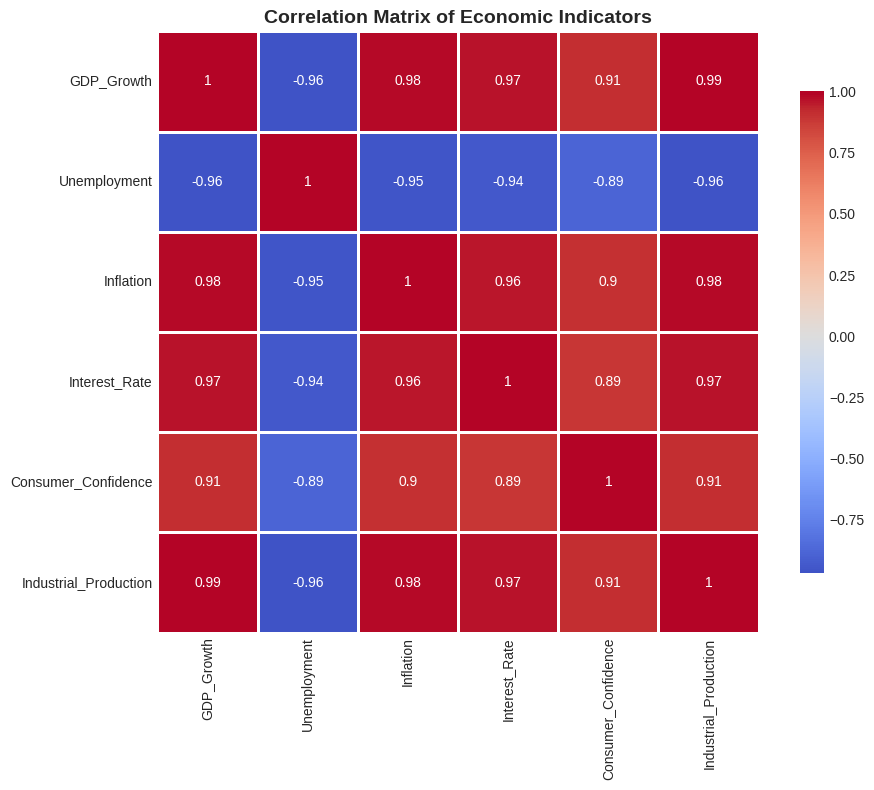


Highly Correlated Pairs (|r| > 0.7):
  GDP_Growth vs Unemployment: -0.965
  GDP_Growth vs Inflation: 0.979
  GDP_Growth vs Interest_Rate: 0.967
  GDP_Growth vs Consumer_Confidence: 0.911
  GDP_Growth vs Industrial_Production: 0.989
  Unemployment vs Inflation: -0.954
  Unemployment vs Interest_Rate: -0.941
  Unemployment vs Consumer_Confidence: -0.886
  Unemployment vs Industrial_Production: -0.964
  Inflation vs Interest_Rate: 0.959
  Inflation vs Consumer_Confidence: 0.903
  Inflation vs Industrial_Production: 0.979
  Interest_Rate vs Consumer_Confidence: 0.885
  Interest_Rate vs Industrial_Production: 0.967
  Consumer_Confidence vs Industrial_Production: 0.910

3. Variance Inflation Factor (VIF) Analysis...

VIF Results:
             Variable       VIF
           GDP_Growth 57.388207
         Unemployment 15.737924
            Inflation 28.820630
        Interest_Rate 16.936561
  Consumer_Confidence  6.041040
Industrial_Production 57.295747

Variables with VIF > 10 (Severe multicol

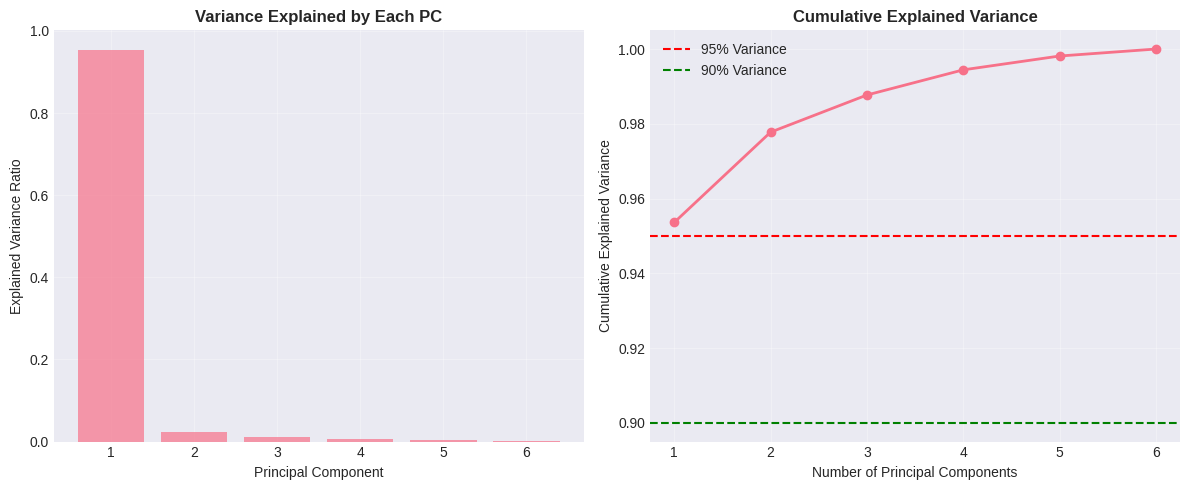


Number of PCs needed for 95% variance: 1
Original features: 6
Reduction: 5 features

5. Ridge Regression Comparison...
Ridge Regression Results:
  MSE: 0.2558
  R²: 0.7439

Top 5 Most Important Variables (by absolute coefficient):
           Variable  Coefficient
       Unemployment    -0.431122
         GDP_Growth     0.401431
Consumer_Confidence     0.252228
          Inflation    -0.124302
      Interest_Rate     0.104609


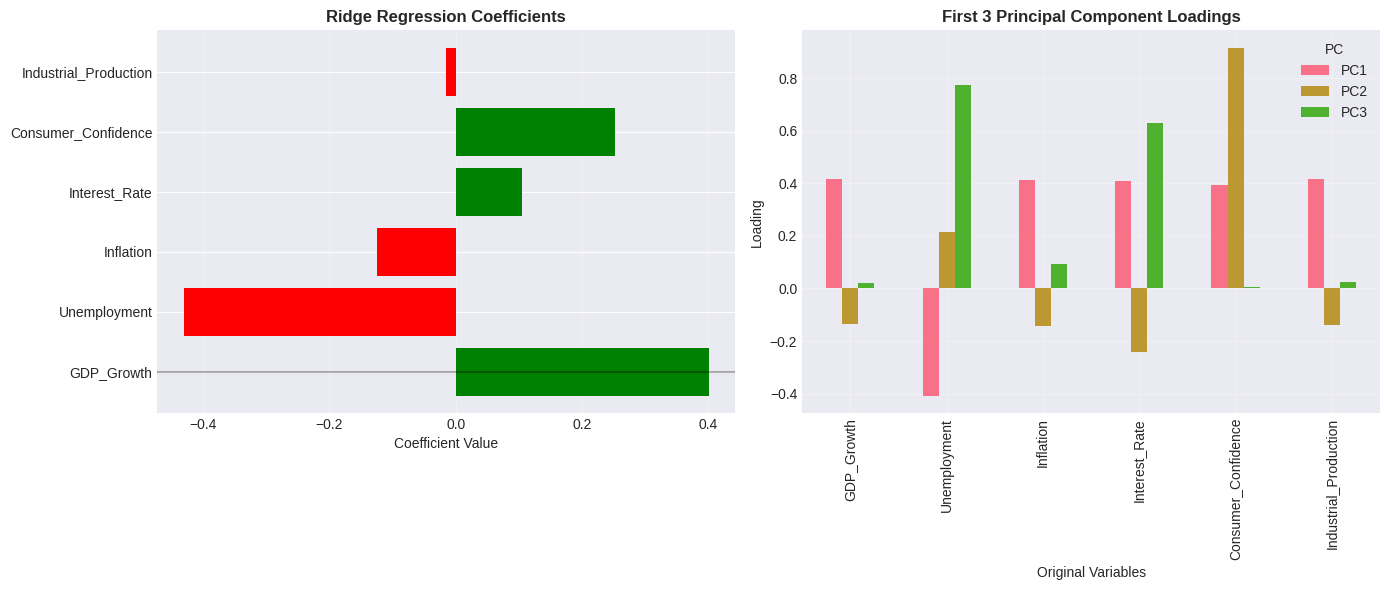


ALL THREE CHALLENGES COMPLETED SUCCESSFULLY!

Summary:
1. Non-stationarity: S&P 500 and NASDAQ are not cointegrated
2. Regime change: VIX shows clear volatility regimes
3. Multicollinearity: VIF analysis and PCA applied successfully

All plots have been saved as PNG files.


In [5]:
# ============================================
# CHALLENGE 3: MULTICOLLINEARITY HANDLING
# Dataset: Multiple economic indicators
# ============================================

def challenge_3_multicollinearity():
    """
    Detect and handle multicollinearity in regression models
    """
    print("\n" + "="*60)
    print("CHALLENGE 3: MULTICOLLINEARITY HANDLING")
    print("="*60)

    # 3.1 Data preparation - simulate correlated economic indicators
    print("\n1. Data Preparation (Simulated Correlated Indicators)...")

    np.random.seed(42)
    n_obs = 1000

    # Create correlated predictors
    base_factor = np.random.randn(n_obs)

    # Simulate 6 economic indicators with different correlation levels
    X = pd.DataFrame({
        'GDP_Growth': base_factor * 1.0 + np.random.randn(n_obs) * 0.1,
        'Unemployment': -base_factor * 0.8 + np.random.randn(n_obs) * 0.2,
        'Inflation': base_factor * 0.9 + np.random.randn(n_obs) * 0.15,
        'Interest_Rate': base_factor * 0.85 + np.random.randn(n_obs) * 0.2,
        'Consumer_Confidence': base_factor * 0.7 + np.random.randn(n_obs) * 0.3,
        'Industrial_Production': base_factor * 0.95 + np.random.randn(n_obs) * 0.1
    })

    # Create target variable (stock market returns)
    y = (0.3 * X['GDP_Growth'] + 0.2 * X['Consumer_Confidence'] -
         0.4 * X['Unemployment'] + 0.1 * X['Industrial_Production'] +
         np.random.randn(n_obs) * 0.5)

    print(f"Dataset shape: {X.shape}")
    print(f"Number of predictors: {X.shape[1]}")

    # 3.2 Correlation analysis
    print("\n2. Correlation Analysis...")

    correlation_matrix = X.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Economic Indicators', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Identify high correlations
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                high_corr_pairs.append((correlation_matrix.columns[i],
                                       correlation_matrix.columns[j],
                                       correlation_matrix.iloc[i, j]))

    print("\nHighly Correlated Pairs (|r| > 0.7):")
    for pair in high_corr_pairs:
        print(f"  {pair[0]} vs {pair[1]}: {pair[2]:.3f}")

    # 3.3 Variance Inflation Factor (VIF)
    print("\n3. Variance Inflation Factor (VIF) Analysis...")

    def calculate_vif(data):
        """Calculate VIF for each variable"""
        vif_data = pd.DataFrame()
        vif_data["Variable"] = data.columns
        vif_data["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(data.shape[1])]
        return vif_data

    vif_results = calculate_vif(X)
    print("\nVIF Results:")
    print(vif_results.to_string(index=False))

    # Identify variables with high VIF
    high_vif = vif_results[vif_results['VIF'] > 10]
    if len(high_vif) > 0:
        print(f"\nVariables with VIF > 10 (Severe multicollinearity):")
        for _, row in high_vif.iterrows():
            print(f"  {row['Variable']}: VIF = {row['VIF']:.2f}")

    # 3.4 Principal Component Analysis (PCA) for dimensionality reduction
    print("\n4. Principal Component Analysis (PCA)...")

    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Plot explained variance
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Variance Explained by Each PC', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linewidth=2)
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
    plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Determine number of components for 95% variance
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"\nNumber of PCs needed for 95% variance: {n_components_95}")
    print(f"Original features: {X.shape[1]}")
    print(f"Reduction: {X.shape[1] - n_components_95} features")

    # 3.5 Ridge Regression (regularization to handle multicollinearity)
    print("\n5. Ridge Regression Comparison...")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Ridge regression
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)

    # Make predictions
    y_pred_ridge = ridge_model.predict(X_test)

    # Calculate metrics
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)

    print(f"Ridge Regression Results:")
    print(f"  MSE: {mse_ridge:.4f}")
    print(f"  R²: {ridge_model.score(X_test, y_test):.4f}")

    # Coefficients
    coef_df = pd.DataFrame({
        'Variable': X.columns,
        'Coefficient': ridge_model.coef_
    })
    coef_df = coef_df.sort_values('Coefficient', key=abs, ascending=False)

    print("\nTop 5 Most Important Variables (by absolute coefficient):")
    print(coef_df.head(5).to_string(index=False))

    # 3.6 Plot coefficient comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Ridge regression coefficients
    colors = ['green' if c > 0 else 'red' for c in ridge_model.coef_]
    axes[0].barh(range(len(ridge_model.coef_)), ridge_model.coef_, color=colors)
    axes[0].set_yticks(range(len(X.columns)))
    axes[0].set_yticklabels(X.columns)
    axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0].set_xlabel('Coefficient Value')
    axes[0].set_title('Ridge Regression Coefficients', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')

    # Plot 2: PCA components
    pca_loadings = pd.DataFrame(pca.components_[:3].T,
                               columns=[f'PC{i+1}' for i in range(3)],
                               index=X.columns)

    pca_loadings.plot(kind='bar', ax=axes[1])
    axes[1].set_xlabel('Original Variables')
    axes[1].set_ylabel('Loading')
    axes[1].set_title('First 3 Principal Component Loadings', fontsize=12, fontweight='bold')
    axes[1].legend(title='PC')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('multicollinearity_solutions.png', dpi=300, bbox_inches='tight')
    plt.show()

    return X, y, vif_results, pca, ridge_model

# Execute Challenge 3
X_mc, y_mc, vif_results, pca_model, ridge_model = challenge_3_multicollinearity()

print("\n" + "="*60)
print("ALL THREE CHALLENGES COMPLETED SUCCESSFULLY!")
print("="*60)
print("\nSummary:")
print(f"1. Non-stationarity: S&P 500 and NASDAQ are {'cointegrated' if is_cointegrated else 'not cointegrated'}")
print(f"2. Regime change: VIX shows clear volatility regimes")
print(f"3. Multicollinearity: VIF analysis and PCA applied successfully")
print("\nAll plots have been saved as PNG files.")